In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
from re import sub
from decimal import Decimal

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv('../../ML/car-sense-Analytics/car_m_v_dataset.csv', skiprows=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    120 non-null    object 
 1   model                    120 non-null    object 
 2   year                     120 non-null    int64  
 3   max                      120 non-null    object 
 4   min                      120 non-null    object 
 5   adult_passangers         120 non-null    int64  
 6   weight                   120 non-null    int64  
 7   transmission             120 non-null    object 
 8   fuel                     120 non-null    object 
 9   tank                     120 non-null    object 
 10  fuel_consumption         119 non-null    float64
 11  4x4/awd                  120 non-null    object 
 12  big_volume_cargo         120 non-null    object 
 13  trunk_size               120 non-null    object 
 14  front_break              1

In [3]:
def normalize_segments(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sed_s_values = ['Sedan-SmallSize'],
        sed_m_values = ['Sedan-MidSize', 'Sedan/MidSize/Hybrid'],
        sed_f_values = ['Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'],
        suv_s_values = ['SUV-City', 'SUV-SmallSize'],
        suv_m_values = ['SUV-MidSize'] ,
        suv_f_values = ['SUV-Fullsize', 'SUV-Fullsize/Hybrid', 'SUV-FullSize'],
        suv_xl_values = ['SUV-ExtendedSize','SUV-ExtendedSize/Hybrid'],
        pu_s_values = ['Pickup-SmallSize'],
        pu_m_values = ['Pickup-MidSize'],
        pu_f_values = ['Pickup-FullSize/Hybrid', 'Pickup-FullSize'],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('raw_segment: [{}]not found.'.format(raw_segment))
    return 'Not found'
    
df['segment_normalized'] = df['segment'].apply(normalize_segments)

In [4]:
def category_classifer(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sedan_values = [
            'Sedan-SmallSize', 'Sedan-MidSize', 'Sedan/MidSize/Hybrid', 
            'Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'
        ],
       
        suv_values = [
            'SUV-City', 'SUV-SmallSize', 'SUV-MidSize', 
            'SUV-Fullsize', 'SUV-Fullsize/Hybrid', 
            'SUV-FullSize','SUV-ExtendedSize', 'SUV-ExtendedSize/Hybrid'
        ],
       
        pu_values = ['Pickup-SmallSize', 'Pickup-MidSize', 'Pickup-FullSize/Hybrid', 'Pickup-FullSize', ],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('category: [{}]not found.'.format(raw_segment))
    return 'Not found'

df['category'] = df['segment'].apply(category_classifer)


In [5]:
def ground_category(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sedan_values = [
            'Sedan-SmallSize', 'Sedan-MidSize', 'Sedan/MidSize/Hybrid', 
            'Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'
        ],
       
        suv_values = [
            'SUV-City', 'SUV-SmallSize', 'SUV-MidSize', 
            'SUV-Fullsize', 'SUV-Fullsize/Hybrid', 
            'SUV-FullSize','SUV-ExtendedSize', 'SUV-ExtendedSize/Hybrid'
        ],
       
        pu_values = ['Pickup-SmallSize', 'Pickup-MidSize', 'Pickup-FullSize/Hybrid', 'Pickup-FullSize', ],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('category: [{}]not found.'.format(raw_segment))
    return 'Not found'

df['category'] = df['segment'].apply(category_classifer)

In [6]:

main_columns = ['brand', 'model']
filtered_df = df[df['dist_axis'].isna()]

df_groupby = df.groupby(['segment_normalized'])['dist_axis'].mean()




print('dist_axis missing values: {}'.format(df['dist_axis'].isnull().sum()))

def fill_missing_dist_axis(row):
    if np.isnan(row['dist_axis']):
        return df_groupby[row['segment_normalized']]
    else:
        return row['dist_axis']



df['dist_axis'] = df.apply(lambda row: fill_missing_dist_axis(row), axis=1)

print('dist_axis missing values: {}'.format(df['dist_axis'].isnull().sum()))
df['dist_axis'] 

dist_axis missing values: 0
dist_axis missing values: 0


0      2.60
1      2.60
2      2.60
3      2.60
4      2.60
       ... 
115    2.77
116    2.77
117    2.81
118    2.90
119    2.27
Name: dist_axis, Length: 120, dtype: float64

/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

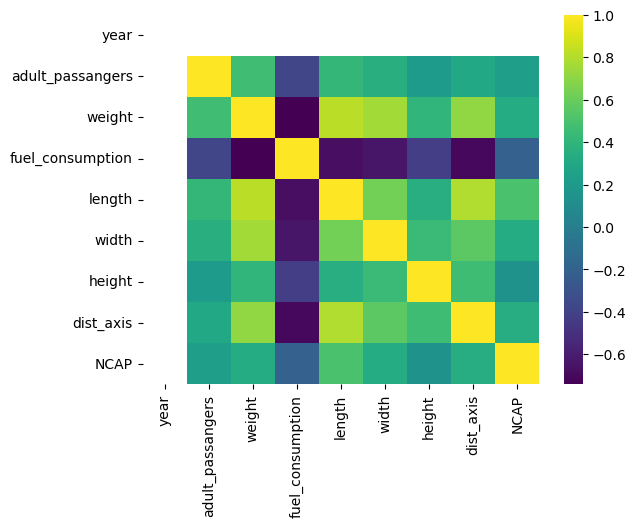

In [7]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')

## Transformations of data

In [8]:


# df['max_price'] = df['max'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['min_price'] = df['min'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['trunk_size_number'] = df['trunk_size'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['transmission_automatic'] = df['transmission'].apply(lambda x: 1 if 'A' in x else 0)

df['weight_number'] = df['weight'].apply(lambda x:Decimal(sub(r'[^\d.]', '', str(x)) ))
# df['tank_number'] = df['tank'].apply(lambda x:Decimal(sub(r'[^\d.]', '', str(x)) ))

cast_boolean = lambda x: 1 if x == 'yes' else 0

# Yes/No Columns
# df['cruise_control_advanced'] = df['cruise_control_advanced'].apply(cast_boolean)
# df['cruise_control'] = df['cruise_control'].apply(cast_boolean)
# df['blind_spot_alert'] = df['blind_spot_alert'].apply(cast_boolean)
# df['rain_sensor'] = df['rain_sensor'].apply(cast_boolean)
df['car_tow'] = df['car_tow'].apply(cast_boolean)
# df['car_pull'] = df['car_pull'].apply(cast_boolean)


In [9]:
# df['height_to_the ground_number'] = df['height_to_the ground']

def cast_height_to_ground(ground):
    value = ground.split('/')[0]
    switcher = {
        'normal': 0,
        'high': 1,
        'extra_high': 2
    }

    return switcher.get(value)

df['ground_clearance'] = df['height_to_the ground'].apply(cast_height_to_ground)


In [10]:
# Delete columns not needed
df = df.drop(columns=[
    'body_type', 'segment', 'max', 'min', 'transmission', 'brand', 'model', 'year', 'weight', 'trunk_size',
    'front_break', 'rear_break', 'braking_assists', 'fuel',
    '4x4/awd', 'big_volume_cargo', 'height_to_the ground', 'tank',
     'front_airbags',	'side_airbags',	'curtain_air_bags',	'knee_air_bags',
    'tire_pressure_monitor', 'emergency_brake',	'reverse_camera','camera_360',
    'bluetooth', 'android_auto/apple+play', 'cruise_control', 'cruise_control_advanced',
    'blind_spot_alert', 'rain_sensor', 'NCAP',  'transmission_automatic', 'car_pull', 'tank_number'
    ],
errors='ignore')

 

df.head(5)

,adult_passangers,fuel_consumption,length,width,height,dist_axis,car_tow,segment_normalized,category,min_price,trunk_size_number,weight_number,ground_clearance
0,5,20.0,4.4,1.6,1.4,2.6,0,sed_s,sedan,316100,475,1035,0
1,5,20.0,4.4,1.6,1.4,2.6,0,sed_s,sedan,331100,475,1035,0
2,5,20.0,4.4,1.6,1.4,2.6,0,sed_s,sedan,341000,475,1035,0
3,5,20.0,4.4,1.6,1.4,2.6,0,sed_s,sedan,356000,475,1035,0
4,5,20.0,4.4,1.6,1.4,2.6,0,sed_s,sedan,392200,475,1035,0


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

numeric_columns = ['adult_passangers', 'weight_number', 'fuel_consumption', 'trunk_size_number', 'length',
                    'min_price', 'height', 'dist_axis', 'ground_clearance', 'width'
                  ]
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df.head(5)



,adult_passangers,fuel_consumption,length,width,height,dist_axis,car_tow,segment_normalized,category,min_price,trunk_size_number,weight_number,ground_clearance
0,0.5,0.599604,0.285714,0.0,0.046243,0.150685,0,sed_s,sedan,0.028334,0.176381,0.007816,0.0
1,0.5,0.599604,0.285714,0.0,0.046243,0.150685,0,sed_s,sedan,0.037554,0.176381,0.007816,0.0
2,0.5,0.599604,0.285714,0.0,0.046243,0.150685,0,sed_s,sedan,0.043639,0.176381,0.007816,0.0
3,0.5,0.599604,0.285714,0.0,0.046243,0.150685,0,sed_s,sedan,0.052858,0.176381,0.007816,0.0
4,0.5,0.599604,0.285714,0.0,0.046243,0.150685,0,sed_s,sedan,0.075108,0.176381,0.007816,0.0


In [12]:
df.columns

Index(['adult_passangers', 'fuel_consumption', 'length', 'width', 'height',
       'dist_axis', 'car_tow', 'segment_normalized', 'category', 'min_price',
       'trunk_size_number', 'weight_number', 'ground_clearance'],
      dtype='object')

## SGD Classifier

In [43]:
df_suv_sedan = df[df['segment_normalized'].isin(['sed_s', 'sed_m', 'sed_f', 'suv_s', 'suv_m', 'suv_f', 'suv_xl', 'city'])]
print(df_suv_sedan.info())
X = df_suv_sedan.drop(columns=[
    'segment_normalized',
    'category'
    ])



X.fillna(0, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 0 to 119
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adult_passangers    103 non-null    float64
 1   fuel_consumption    102 non-null    float64
 2   length              103 non-null    float64
 3   width               103 non-null    float64
 4   height              103 non-null    float64
 5   dist_axis           103 non-null    float64
 6   car_tow             103 non-null    int64  
 7   segment_normalized  103 non-null    object 
 8   category            103 non-null    object 
 9   min_price           103 non-null    float64
 10  trunk_size_number   103 non-null    float64
 11  weight_number       103 non-null    float64
 12  ground_clearance    103 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 11.3+ KB
None


In [44]:
y = df_suv_sedan['segment_normalized']

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.3)


In [46]:
# Create classifier
clf = SGDClassifier(loss='log_loss', alpha=0.0001,
                    max_iter=10000)

In [47]:
# Train the classifier
clf.fit(X_train, y_train)

SGDClassifier(loss='log_loss', max_iter=10000)

In [48]:
# Make predictions
y_pred = clf.predict(X_test)
y_pred

array(['suv_f', 'suv_f', 'suv_s', 'sed_m', 'suv_f', 'sed_m', 'suv_xl',
       'suv_s', 'suv_s', 'city', 'sed_m', 'city', 'sed_m', 'sed_m',
       'sed_s', 'suv_s', 'sed_m', 'suv_f', 'suv_xl', 'sed_s', 'sed_m',
       'sed_m', 'sed_m', 'sed_m', 'suv_s', 'city', 'suv_xl', 'suv_s',
       'sed_s', 'suv_xl', 'suv_xl'], dtype='<U6')

In [49]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7096774193548387


In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        city       1.00      1.00      1.00         3
       sed_f       0.00      0.00      0.00         3
       sed_m       0.50      0.83      0.62         6
       sed_s       0.67      0.50      0.57         4
       suv_f       0.75      0.75      0.75         4
       suv_m       0.00      0.00      0.00         2
       suv_s       0.83      1.00      0.91         5
      suv_xl       0.80      1.00      0.89         4

    accuracy                           0.71        31
   macro avg       0.57      0.64      0.59        31
weighted avg       0.61      0.71      0.65        31



/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## SGD for Categories City, Sedan & SUV


In [29]:
df_suv_sedan = df[df['category'].isin(['sedan', 'city', 'suv'])]

print(df_suv_sedan.info())
X = df_suv_sedan.drop(columns=[
    'segment_normalized', 'category'
    ])

X.fillna(0, inplace=True)


y = df_suv_sedan['category']



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.3)


# Create classifier
clf = SGDClassifier(loss='log_loss', alpha=0.0001,
                    max_iter=10000)


# Train the classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 0 to 119
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adult_passangers    103 non-null    float64
 1   fuel_consumption    102 non-null    float64
 2   length              103 non-null    float64
 3   width               103 non-null    float64
 4   height              103 non-null    float64
 5   dist_axis           103 non-null    float64
 6   car_tow             103 non-null    int64  
 7   segment_normalized  103 non-null    object 
 8   category            103 non-null    object 
 9   min_price           103 non-null    float64
 10  trunk_size_number   103 non-null    float64
 11  weight_number       103 non-null    float64
 12  ground_clearance    103 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 11.3+ KB
None
Accuracy: 0.9032258064516129
              precision    recall  f1-score   support

        city